In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import itertools

import json
import os

import networkx as nx

import random

from joblib import Parallel, delayed

import logging

from sklearn.decomposition import PCA

In [39]:
from typing import List

In [40]:
import joblib

In [41]:
%load_ext autoreload
%autoreload 2
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from Benchmarks.benchmark import generate_save_benchmark_dataset

from CustomAbstraction.CustomAbstractionHelper import StateModel, print_states, collect_state_field, getStateTransitionMatrix, calculate_state_transition

# from QuadraticConstraintModel import train_COF_on_leaves, get_h_from_COF

# from QuadraticConstraintModel import get_feature_bounds_from_COF, predict_from_COF, get_elevated_vertices

# from QuadraticConstraintModel import get_leaf_samples

from Optimizers.QuadraticConstraintModel import gurobi_minimax, cvxpy_minimax, train_States_on_leaves_parallel, predict_by_bounds, predict_with_tree
from Optimizers.QuadraticConstraintModel import counts_of_daviation_in_testing
from Helping_Code.HelpingFunctions import normalized_root_mean_square_error

from SpaceEx.CustomAbstraction_to_SpaceEx import export_spaceex
from SpaceEx.RunSpaceexTest import run_spaceex


In [43]:
from Helping_Code.HelpingFunctions import get_leaf_samples
from Helping_Code.HelpingFunctions import load_dataset

In [44]:
from Helping_Code import CustomHyperrectangle
from Helping_Code.plot import CustomPlotClass

# customHyperrectangle = CustomHyperrectangle.CustomHyperrectangle()
customPlot = CustomPlotClass.CustomPlotClass()

# Helping code

In [45]:
def plotHyperrectanglesOfStateSpace(vertices_of_hyperrectangle, title="partitions of state space", savePath=None):
    num_of_vertices = vertices_of_hyperrectangle[0].shape[0]
    # print(f"number of vertices = {num_of_vertices}")
    if num_of_vertices == 4:
        customPlot.draw2DHyperrectanglesWithVertices(
            vertices_of_hyperrectangle,
            color='#8f9119',
            title=title,
            savePath=savePath
        )

    elif num_of_vertices == 8:
        # 3D Hyperrectangles
        customPlot.draw3DHyperrectanglesWithVertices(
            vertices_of_hyperrectangle,
            interactive=True,
            title=title,
            savePath=savePath
        )
    else:
        # Higher-dimensional hyperrectangles → reduce to 3D using PCA
        projected_vertices = []
        for verts in vertices_of_hyperrectangle:
            pca = PCA(n_components=3)
            verts_reduced = pca.fit_transform(verts)
            projected_vertices.append(verts_reduced)

        customPlot.draw3DHyperrectanglesWithVertices(
            projected_vertices,
            interactive=True,
            title=title,
            savePath=savePath
        )


def plotElivatedHyperrectangles(vertices_of_hyperrectangle, elevated_vertices_of_hyperrectangle, title="Elevated Hyper Rectangles", savePath=None):
    num_of_vertices = vertices_of_hyperrectangle[0].shape[0]

    if num_of_vertices == 4:
        # 2D polytopes
        customPlot.drawDual2DHyperrectanglesWithVertices(
            vertices_of_hyperrectangle,
            elevated_vertices_of_hyperrectangle,
            color1='#8f9119',
            color2='#197b91',
            title=title,
            savePath=savePath
        )
    elif num_of_vertices == 8:
        # 3D polytopes
        customPlot.drawDual3DHyperrectanglesWithVertices(
            vertices_of_hyperrectangle,
            elevated_vertices_of_hyperrectangle,
            color1='#8f9119',
            color2='#197b91',
            title=title,
            savePath=savePath
        )
    else:
        # Higher-dimensional hyperrectangles → reduce to 3D using PCA
        projected_vertices = []
        for verts in vertices_of_hyperrectangle:
            pca = PCA(n_components=3)
            verts_reduced = pca.fit_transform(verts)
            projected_vertices.append(verts_reduced)

        elevated_projected_vertices = []
        for verts in elevated_vertices_of_hyperrectangle:
            pca = PCA(n_components=3)
            verts_reduced = pca.fit_transform(verts)
            elevated_projected_vertices.append(verts_reduced)

        
        # Fallback for other cases
        customPlot.drawDual2DHyperrectanglesWithVertices(
            projected_vertices,
            elevated_projected_vertices,
            title=title,
            savePath=savePath
        )



def plotDistanceBetweenTwoHyperrectangles(elevated_vertices, vertices_of_hyperrectangle, savePath="", title="Hyperrectangle Minimum Distance"):
    
    # Get closest points and distance
    X_opt, Xp_opt, min_distance = customHyperrectangle.minimize_hyperrectangle_distance_dual(
        elevated_vertices, vertices_of_hyperrectangle
    )
    
    # Determine dimension
    dim = elevated_vertices.shape[1]
    
    if dim == 2:
        # 2D plotting
        plt.figure()
        
        def plot_2d_hyperrectangle(vertices, color='cyan', alpha=0.3):
            from scipy.spatial import ConvexHull
            hull = ConvexHull(vertices)
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], color=color, alpha=alpha)
            plt.plot(vertices[hull.vertices, 0], vertices[hull.vertices, 1], 'k-', linewidth=1)
        
        # Plot rectangles
        plot_2d_hyperrectangle(elevated_vertices, color='cyan', alpha=0.3)
        plot_2d_hyperrectangle(vertices_of_hyperrectangle, color='orange', alpha=0.3)
        
        # Plot closest points
        plt.scatter(*X_opt, color='blue', s=50, label='Closest point on elevated rectangle')
        plt.scatter(*Xp_opt, color='red', s=50, label='Closest point on rectangle')
        
        # Draw line connecting closest points
        plt.plot([X_opt[0], Xp_opt[0]], [X_opt[1], Xp_opt[1]], color='green', linewidth=2, label=f'Min distance: {min_distance:.3f}')
        
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(title)
        plt.legend()
        plt.axis('equal')
        plt.savefig(savePath)
        plt.show()
        
    else:
        # 3D plotting
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        def plot_3d_hyperrectangle(ax, verts, color='cyan', alpha=0.3):
            faces = np.array([[0, 1, 3, 2], [0, 1, 5, 4], [0, 2, 6, 4],
                              [1, 3, 7, 5], [2, 3, 7, 6], [4, 5, 7, 6]])
            poly3d = [[verts[idx] for idx in face] for face in faces]
            ax.add_collection3d(Poly3DCollection(poly3d, facecolors=color, linewidths=1, edgecolors='k', alpha=alpha))
        
        # Plot hyperrectangles
        plot_3d_hyperrectangle(ax, elevated_vertices, color='cyan', alpha=0.3)
        plot_3d_hyperrectangle(ax, vertices_of_hyperrectangle, color='orange', alpha=0.3)
        
        # Plot closest points
        ax.scatter(*X_opt, color='blue', s=50, label='Closest point on elevated hyperrectangle')
        ax.scatter(*Xp_opt, color='red', s=50, label='Closest point on hyperrectangle')
        
        # Draw line connecting closest points
        line_pts = np.vstack([X_opt, Xp_opt])
        ax.plot(line_pts[:,0], line_pts[:,1], line_pts[:,2], color='green', linewidth=2, label=f'Min distance: {min_distance:.3f}')
        
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title(title)
        ax.legend()
        plt.savefig(savePath)
        plt.show()
    


In [46]:
import matplotlib.pyplot as plt
import networkx as nx

# Define your states and transition_to
# Each state will have an index and a list of transitions (indices of next states)

def plot_state_automata(states, title, savePath = None):
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes (states)
    for i, state in enumerate(states):
        G.add_node(i, label=state.state_identifier)
    
    # Add edges based on transitions
    for i, state in enumerate(states):
        for next_state_idx in state.transition_to:
            G.add_edge(i, next_state_idx, label=f'{states[i].state_identifier} -> {states[next_state_idx].state_identifier}')
    
    # Create a layout for the graph (positions of nodes)
    pos = nx.spring_layout(G, seed=42)  # This gives a good-looking layout
    
    # Draw the graph
    plt.figure(figsize=(8, 8))
    
    # Draw nodes (states)
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue', alpha=0.7)
    
    # Draw edges (transitions)
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, edge_color='gray')
    
    # Draw labels for nodes (state identifiers)
    nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold')
    
    # Draw edge labels (transition labels)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
    
    # Title and display the plot
    plt.title("Automaton State Transition Graph", fontsize=18)
    plt.axis('off')  # Hide axes for better aesthetics
    if savePath:
        plt.savefig(savePath, dpi=300)
    plt.show()


In [47]:
name_of_systems = [  "jet", "exp", "steam","nl1", "nl2", "tank"] # "navigation_old", "lin", "vdp", "sine2d", "tank"
list_of_n_samples = [ 10000, 100000, 30000, 60000, 100000, 1000000] # 500000, 

In [48]:
# initials = { "jet" : 'x0>= 0.45 & x0 <= 0.5 & x1 >= -0.6 & x1 <= -0.55 & u0==0 & u1==0 & t==0 ',
#              "exp" : 'x0>=0.45 & x0<=0.5 & x1>=0.86 & x1 <= 0.91 & u0==0 & u1==0 & t==0 ',
#              "steam": 'x0>=0.7 & x0<=0.75 & x1>=-0.05 & x1<=0.05 & x2>=0.7 & x2<=0.75 & u0==0 & u1==0 & t==0',
#              "nl1": 'x0>= 0 & x0 <= 0.05 & x1 >= 0 & x1 <= 0.1 & u0==0 & u1==0 & t==0',
#              "nl2": 'x0<=0.025 & x0>=-0.025 & x1>=-0.9 & x1 <= -0.85 & u0==0 & u1==0 & t==0 ',
#              # tank --> 'x0<=0.01 & x0 >= 0.0 & u0==0 & t==0 '
#            }
initial_boxes = {
    "jet" :[(0.45, 0.5),    (-0.6,  -0.55)],        # 1: x0, x1
    "exp" : [(0.45, 0.5),    (0.86,   0.91)],        # 2: x0, x1
    "steam": [(0.7,  0.75),   (-0.05,  0.05), (0.7, 0.75)],  # 3: x0, x1, x2  <-- 3D
    "nl1": [(0.0,  0.05),   (0.0,    0.1)],         # 4: x0, x1
    "nl2": [(-0.025, 0.025),(-0.9,  -0.85)],        # 5: x0, x1
    "tank": [(0.0,  0.01)],                  # 6: x0 only (no x1 given)
}
# forbiddens = {
#     "jet" : "x0 >= 0.3 & x0 <=0.35 & x1 >=0.5 & x1 <=0.6 ",
#     "exp" : 'x0 >= 0.3 & x0 <=0.4 & x1 >=0.5 & x1 <=0.6',
#     "steam": 'x0 >=0.5 & x0 <=0.6 & x1 >=-0.4 & x1 <=-0.3 & x2 >=0.7 & x2 <=0.8',
#     "nl1": 'x0>=0.35 & x0 <=0.45 & x1>=0.1 & x1<=0.2',
#     "nl2": 'x0 <=0.05 & x0 >= -0.05 & x1 >= -0.8 & x1 <=-0.7',
#     # --> tank'x0 >= 2.0'
# }

unsafe_boxes = {
    "jet" : [(0.3, 0.35),   (0.5, 0.6)],                 # 1: x0, x1
    "exp" : [(0.3, 0.4),    (0.5, 0.6)],                 # 2: x0, x1
    "steam": [(0.5, 0.6),    (-0.4, -0.3), (0.7, 0.8)],   # 3: x0, x1, x2 (3D)
    "nl1": [(0.35, 0.45),  (0.1, 0.2)],                 # 4: x0, x1
    "nl2": [(-0.05, 0.05), (-0.8, -0.7)],               # 5: x0, x1
    "tank": [(2.0, None)],                                # 6: x0 lower-bounded only
}


# Runing for testing error

In [49]:
import os, csv, time, joblib
from datetime import datetime

RESULTS_CSV = "results_summary.csv"  # change path if you want it elsewhere

def append_results(csv_path: str, row: dict):
    """Append a single result row to csv_path, creating header if needed."""
    os.makedirs(os.path.dirname(csv_path) or ".", exist_ok=True)
    header = [
        "timestamp",
        "sys_name",
        "n_samples",
        "final_max_leaf_nodes",
        "states_len",
        "time_sec",
        "forbidden_reached_final",
        "T",
        "cfg_sampling_time",
    ]
    file_exists = os.path.exists(csv_path)
    write_header = (not file_exists) or os.path.getsize(csv_path) == 0
    with open(csv_path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=header)
        if write_header:
            w.writeheader()
        w.writerow(row)

# ---- your loop, with timing + saving once when loop ends ----
for sys_name in name_of_systems[:1]:
    

    for n_samples in list_of_n_samples[:1]:
        if sys_name == "navigation_old":
            X, y = load_dataset(
                f"Dataset/{sys_name}/{sys_name}_{n_samples}/data_{sys_name}_{n_samples}.csv",
                num_attributes=4, num_classes=4
            )
        else:
            X, y = generate_save_benchmark_dataset(benchmark_name=sys_name, n_samples=n_samples)

        print("Name of the System = ", sys_name)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        print(f" Shape of X_Training = {X_train.shape} \n Shape of X_Testing = {X_test.shape}")
        print(f" Shape of Y_Training = {y_train.shape} \n Shape of Y_Testing = {y_test.shape}")

        current_max_leaf_nodes = 2
        loop_flag = True


        
        # parameters you also want saved with the results
        T_param = 1.5
        cfg_sampling_time_param = 1

        while loop_flag:

            sys_start = time.perf_counter()  # total wall time per experiment
            # track the *final* metrics you want to save (only when loop ends)
            final_metrics = {
                
                "states_len": None,
                "final_max_leaf_nodes": None,
                "forbidden_reached_final": None,
            }

            print("Number of the Leaves = ", current_max_leaf_nodes)

            tree = DecisionTreeRegressor(max_leaf_nodes=current_max_leaf_nodes)
            tree.fit(X_train, y_train)

            

            states = train_States_on_leaves_parallel(
                X_train, y_train, tree, optimizer="gurobi", n_jobs=-1
            )
            

            testing_daviation_counts = counts_of_daviation_in_testing(X_test, y_test, states)
            print(f"Number of samples have daviation greater the respective h {testing_daviation_counts}")
            

            '''
            model_folder_path = (
                f"/Users/khalilulrehman/Academic/Phd Italy 2023_26/University of LAquila/"
                f"Research Papers tasks/Benchmarks_Systems/Robust Control for Dynamical Systems "
                f"With Non-Gaussian Noise via Formal Abstractions/Neural Abstractions V2/SpaceEx/"
                f"experiments/{sys_name}_{n_samples}/"
            )
            '''
            model_folder_path = f"/home/devunivaq/ResearchTasks/Neural-Abstractions-V2/SpaceEx/experiments/{sys_name}_{n_samples}/"
           
            os.makedirs(model_folder_path, exist_ok=True)

            export_spaceex(
                states=states,
                out_xml_path=f"{model_folder_path}/{sys_name}_{n_samples}_{current_max_leaf_nodes}_CA_spaceex.xml",
                system_name=f"{sys_name}_{n_samples}_{current_max_leaf_nodes}_State_CustomAbstraction",
                T=T_param,
                initial_box=initial_boxes[sys_name],
                unsafe_box=unsafe_boxes[sys_name],
                init_mode="init_location",  # NA-like
                include_intermediate_transitions = False,
                cfg_scenario="phaver",
                cfg_sampling_time=cfg_sampling_time_param,
            )

            forbidden_reached, output_text, error_text, polygons = run_spaceex(
                folder_model_xml_path=model_folder_path,
                sapceex_path="",
                # "/Users/khalilulrehman/ExtraToolsInstalledHere/spaceex_exe_osx2/",
                model_file=f"{sys_name}_{n_samples}_{current_max_leaf_nodes}_CA_spaceex.xml",
                cfg_file=f"{sys_name}_{n_samples}_{current_max_leaf_nodes}_CA_spaceex.cfg",
                output_file =f"{sys_name}_{n_samples}_{current_max_leaf_nodes}_CA_spaceex.csv"
            )
            print("Forbidden state values reached?", "Yes" if forbidden_reached else "No")

            # update loop condition
            loop_flag = forbidden_reached or not (counts_of_daviation_in_testing == 0)
            current_max_leaf_nodes += 2

           
            # collect the final metrics for CSV
            final_metrics.update(
                
                states_len=len(states),
                final_max_leaf_nodes=current_max_leaf_nodes - 2,
                forbidden_reached_final=bool(forbidden_reached),
            )

    # after finishing this sys_name, compute elapsed time and append a single CSV row
            elapsed = time.perf_counter() - sys_start
            append_results(
                RESULTS_CSV,
                {
                    "timestamp": datetime.now().isoformat(timespec="seconds"),
                    "sys_name": sys_name,
                    "n_samples": n_samples,
                    "final_max_leaf_nodes": final_metrics["final_max_leaf_nodes"],
                    
                    "states_len": final_metrics["states_len"],
                    "time_sec": round(elapsed, 3),
                    "forbidden_reached_final": final_metrics["forbidden_reached_final"],
                    "T": T_param,
                    "cfg_sampling_time": cfg_sampling_time_param,
                },
            )
            print(f"[Saved] {sys_name} summary -> {RESULTS_CSV}")


Loaded dataset from Dataset/jet/jet_10000/data_jet_10000.csv
Name of the System =  jet
 Shape of X_Training = (9000, 2) 
 Shape of X_Testing = (1000, 2)
 Shape of Y_Training = (9000, 2) 
 Shape of Y_Testing = (1000, 2)
Number of the Leaves =  2
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Number of samples have daviation greater the respective h 842
Forbidden state values reached? Yes
[Saved] jet summary -> results_summary.csv
Number of the Leaves =  4
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Number of samples have daviation greater the respective h 953
Forbidden state values reached? Yes
[Saved] jet summary -> results_summary.csv
Number of the Leaves =  6
R

KeyboardInterrupt: 

In [52]:
import os, csv, time, joblib
from datetime import datetime

RESULTS_CSV = "results_summary.csv"  # change path if you want it elsewhere

def append_results(csv_path: str, row: dict):
    """Append a single result row to csv_path, creating header if needed."""
    os.makedirs(os.path.dirname(csv_path) or ".", exist_ok=True)
    header = [
        "timestamp",
        "sys_name",
        "n_samples",
        "final_max_leaf_nodes",
        "states_len",
        "time_sec",
        "forbidden_reached_final",
        "T",
        "cfg_sampling_time",
    ]
    file_exists = os.path.exists(csv_path)
    write_header = (not file_exists) or os.path.getsize(csv_path) == 0
    with open(csv_path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=header)
        if write_header:
            w.writeheader()
        w.writerow(row)

# ---- your loop, with timing + saving once when loop ends ----
for sys_name in name_of_systems[:1]:
    

    for n_samples in list_of_n_samples[:1]:
        if sys_name == "navigation_old":
            X, y = load_dataset(
                f"Dataset/{sys_name}/{sys_name}_{n_samples}/data_{sys_name}_{n_samples}.csv",
                num_attributes=4, num_classes=4
            )
        else:
            X, y = generate_save_benchmark_dataset(benchmark_name=sys_name, n_samples=n_samples)

        print("Name of the System = ", sys_name)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        print(f" Shape of X_Training = {X_train.shape} \n Shape of X_Testing = {X_test.shape}")
        print(f" Shape of Y_Training = {y_train.shape} \n Shape of Y_Testing = {y_test.shape}")

        current_max_leaf_nodes = 2
        loop_flag = True


        
        # parameters you also want saved with the results
        T_param = 1.5
        cfg_sampling_time_param = 1

        while loop_flag:

            sys_start = time.perf_counter()  # total wall time per experiment
            # track the *final* metrics you want to save (only when loop ends)
            final_metrics = {
                
                "states_len": None,
                "final_max_leaf_nodes": None,
                "forbidden_reached_final": None,
            }

            print("Number of the Leaves = ", current_max_leaf_nodes)

            tree = DecisionTreeRegressor(max_leaf_nodes=current_max_leaf_nodes)
            tree.fit(X_train, y_train)

            

            states = train_States_on_leaves_parallel(
                X_train, y_train, tree, optimizer="gurobi", n_jobs=-1
            )
            

            testing_daviation_counts = counts_of_daviation_in_testing(X_test, y_test, states, error_bound=0.01)
            print(f"Number of samples have daviation greater the respective h {testing_daviation_counts}")
            

            '''
            model_folder_path = (
                f"/Users/khalilulrehman/Academic/Phd Italy 2023_26/University of LAquila/"
                f"Research Papers tasks/Benchmarks_Systems/Robust Control for Dynamical Systems "
                f"With Non-Gaussian Noise via Formal Abstractions/Neural Abstractions V2/SpaceEx/"
                f"experiments/{sys_name}_{n_samples}/"
            )
            '''
            model_folder_path = f"/home/devunivaq/ResearchTasks/Neural-Abstractions-V2/SpaceEx/experiments/{sys_name}_{n_samples}/"
           
            os.makedirs(model_folder_path, exist_ok=True)

            export_spaceex(
                states=states,
                out_xml_path=f"{model_folder_path}/{sys_name}_{n_samples}_{current_max_leaf_nodes}_CA_spaceex.xml",
                system_name=f"{sys_name}_{n_samples}_{current_max_leaf_nodes}_State_CustomAbstraction",
                T=T_param,
                initial_box=initial_boxes[sys_name],
                unsafe_box=unsafe_boxes[sys_name],
                init_mode="init_location",  # NA-like
                include_intermediate_transitions = False,
                cfg_scenario="phaver",
                cfg_sampling_time=cfg_sampling_time_param,
            )

            forbidden_reached, output_text, error_text, polygons = run_spaceex(
                folder_model_xml_path=model_folder_path,
                sapceex_path="",
                # "/Users/khalilulrehman/ExtraToolsInstalledHere/spaceex_exe_osx2/",
                model_file=f"{sys_name}_{n_samples}_{current_max_leaf_nodes}_CA_spaceex.xml",
                cfg_file=f"{sys_name}_{n_samples}_{current_max_leaf_nodes}_CA_spaceex.cfg",
                output_file =f"{sys_name}_{n_samples}_{current_max_leaf_nodes}_CA_spaceex.csv"
            )
            print("Forbidden state values reached?", "Yes" if forbidden_reached else "No")

            # update loop condition
            loop_flag = forbidden_reached or counts_of_daviation_in_testing != 0
            current_max_leaf_nodes += 2

           
            # collect the final metrics for CSV
            final_metrics.update(
                
                states_len=len(states),
                final_max_leaf_nodes=current_max_leaf_nodes - 2,
                forbidden_reached_final=bool(forbidden_reached),
            )

    # after finishing this sys_name, compute elapsed time and append a single CSV row
            elapsed = time.perf_counter() - sys_start
            append_results(
                RESULTS_CSV,
                {
                    "timestamp": datetime.now().isoformat(timespec="seconds"),
                    "sys_name": sys_name,
                    "n_samples": n_samples,
                    "final_max_leaf_nodes": final_metrics["final_max_leaf_nodes"],
                    
                    "states_len": final_metrics["states_len"],
                    "time_sec": round(elapsed, 3),
                    "forbidden_reached_final": final_metrics["forbidden_reached_final"],
                    "T": T_param,
                    "cfg_sampling_time": cfg_sampling_time_param,
                },
            )
            print(f"[Saved] {sys_name} summary -> {RESULTS_CSV}")


Loaded dataset from Dataset/jet/jet_10000/data_jet_10000.csv
Name of the System =  jet
 Shape of X_Training = (9000, 2) 
 Shape of X_Testing = (1000, 2)
 Shape of Y_Training = (9000, 2) 
 Shape of Y_Testing = (1000, 2)
Number of the Leaves =  2
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Number of samples have daviation greater the respective h 957
Forbidden state values reached? Yes
[Saved] jet summary -> results_summary.csv
Number of the Leaves =  4
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Number of samples have daviation greater the respective h 662
Forbidden state values reached? Yes
[Saved] jet summary -> results_summary.csv
Number of the Leaves =  6
R

KeyboardInterrupt: 

In [26]:
from SpaceEx.trajectories_from_states_customAbstraction import run_all_trajectories

In [27]:
for sys_name in name_of_systems:
    for n_samples in list_of_n_samples[:1]:
        states_reloaded: List[StateModel] = joblib.load(f"Dataset/{sys_name}/{sys_name}_{n_samples}/{sys_name}_{n_samples}_states.pkl")
        run_all_trajectories(states_reloaded, initial_boxes[sys_name], dt=0.01, T=20,
                                 u_mode="plus", dims=(0, 1), forbidden_box=unsafe_boxes[sys_name], 
                             save_path=f"Dataset/{sys_name}/{sys_name}_{n_samples}/{sys_name}_{n_samples}_state_tran_init_safety.png",
                            title = f"Trajectory of abstraction of {sys_name}")


FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/jet/jet_10000/jet_10000_states.pkl'

In [43]:
print_states(states, fields_to_print=['h'])

State 13, h=0.12835831599507894
State 11, h=0.12908652149126598
State 14, h=0.1286273868622173
State 10, h=0.1286542532327064
State 12, h=0.1286235170523362
State 9, h=0.12906955566653963
State 7, h=0.12960639627959336
State 8, h=0.1297043694537877


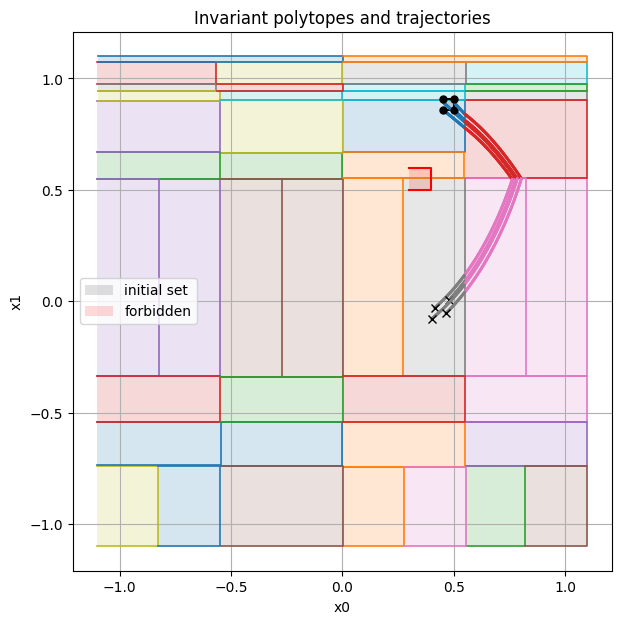

In [57]:
exp_states_reloaded: List[StateModel] = joblib.load("Dataset/exp/exp_100000/exp_100000_states.pkl")
run_all_trajectories(exp_states_reloaded, initial_boxes["exp"], dt=0.01, T=2,
                         u_mode="plus", dims=(0, 1), forbidden_box=unsafe_boxes["exp"])


In [29]:
h_values = collect_state_field(states, field_name='h')
h_values

[1.0948376989052328e-07,
 2.1935366527509377e-07,
 3.254613350750949e-08,
 4.176961039236319e-07,
 3.1577687387453343e-07,
 5.8580453386557555e-08,
 5.759993983739301e-07,
 4.6442879881381085e-08,
 1.0064001773019745e-07,
 1.7998929133620456e-07,
 4.7123272571142536e-08,
 1.2342215514220186e-07,
 1.1349269649143057e-07,
 5.403404279732164e-07,
 9.958166609253269e-08,
 8.20690708737461e-08,
 1.628424065696064e-07,
 1.359135651018085e-07,
 2.139426696531927e-07,
 1.1394174760194186e-07,
 5.11281558120672e-08,
 1.1401223455856826e-07,
 3.761125861352678e-07,
 1.6954897346971663e-07,
 1.997231279048113e-07,
 1.050853170683446e-07,
 6.831638300984313e-08,
 4.3371931372772385e-08,
 7.746440586303726e-08,
 2.0465861724909232e-07,
 1.1942665416214168e-08,
 2.714726768222715e-07,
 1.8444241144416977e-07,
 9.024275683761954e-08,
 7.7432240419075e-08,
 2.5786205558840986e-07,
 7.175021165137788e-08,
 2.008793628060403e-07,
 1.317594672172217e-07,
 4.083906916493346e-08,
 8.868110743059181e-08,
 2

In [30]:
vertices = collect_state_field(states, field_name='vertices')
elevated_vertices = collect_state_field(states, field_name='image_vertices')

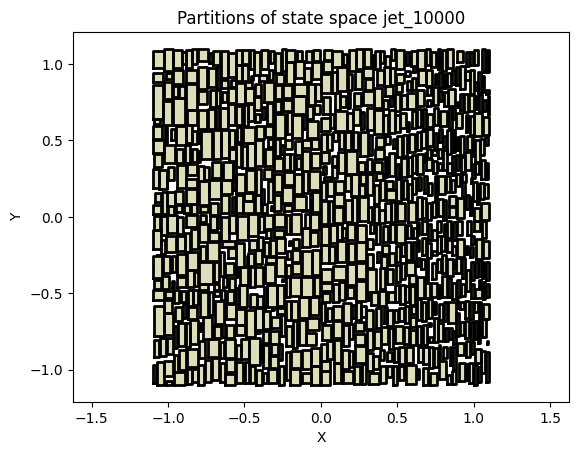

In [31]:

plotHyperrectanglesOfStateSpace(vertices, 
                                title=f"Partitions of state space {sys_name}_{n_samples}")



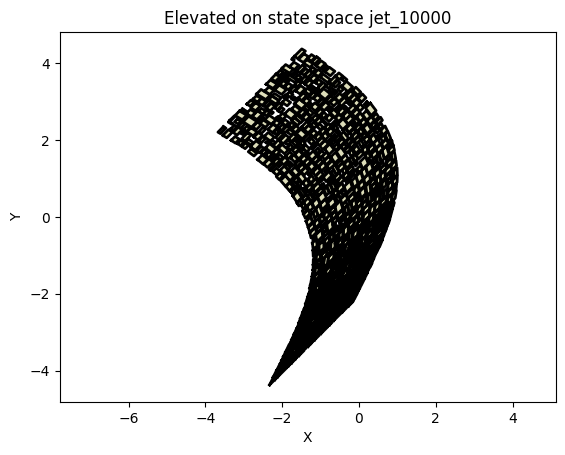

In [32]:

plotHyperrectanglesOfStateSpace(elevated_vertices, 
                                title=f"Elevated on state space {sys_name}_{n_samples}")



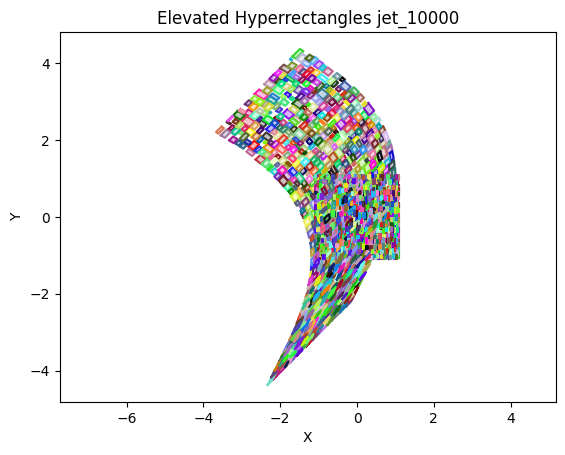

In [33]:

# Plot Dual Hyperrectangles
plotElivatedHyperrectangles(vertices, 
                            elevated_vertices,
                            savePath = None, title=f"Elevated Hyperrectangles {sys_name}_{n_samples}")



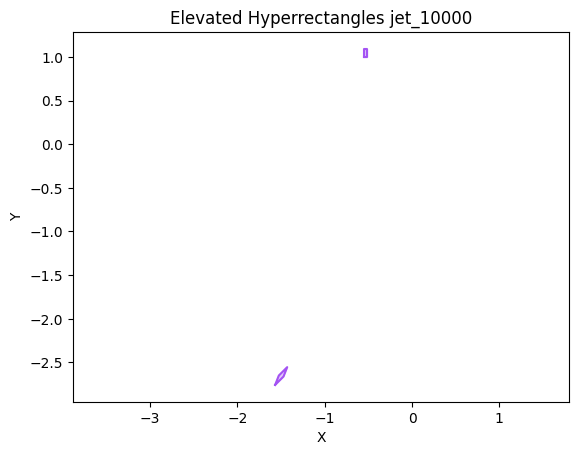

In [34]:

# Plot only one Dual Hyperrectangle
plotElivatedHyperrectangles(vertices[:1], 
                            elevated_vertices[:1],
                            savePath = None, title=f"Elevated Hyperrectangles {sys_name}_{n_samples}")



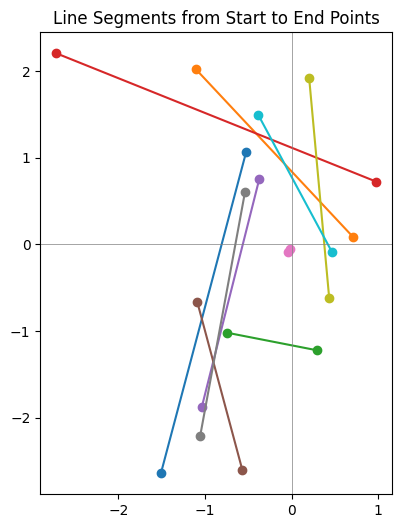

In [35]:
starts = X_train[:10]
ends = y_train[:10]
# Plot lines
plt.figure(figsize=(6,6))
for s, e in zip(starts, ends):
    plt.plot([s[0], e[0]], [s[1], e[1]], marker='o')

plt.axhline(0, color='gray', lw=0.5)  # optional axis lines
plt.axvline(0, color='gray', lw=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Line Segments from Start to End Points")
plt.show()

/Users/khalilulrehman/Academic/Phd Italy 2023_26/University of LAquila/Research Papers tasks/Benchmarks_Systems/Robust Control for Dynamical Systems With Non-Gaussian Noise via Formal Abstractions/Neural Abstractions/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


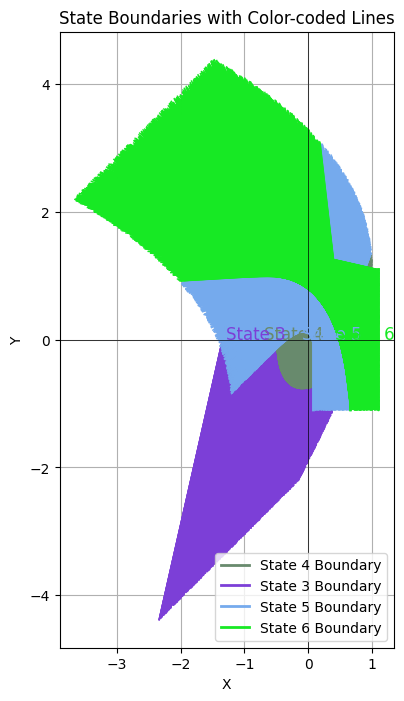

In [385]:
# Plotting the states and lines
plt.figure(figsize=(8, 8))

# Define a color map for the states
state_colors = {state.state_identifier: np.random.rand(3,) for state in states}

# Loop through states and plot their boundaries and lines
for state in states:
    color = state_colors[state.state_identifier]
    
    # Plot the boundary for each state using its vertices or bounds
    if state.vertices is not None:
        plt.plot(state.vertices[:, 0], state.vertices[:, 1], color=color, lw=2, label=f"State {state.state_identifier} Boundary")
    
    # Loop through X_train and y_train and plot lines for each state
    for idx, state_idx in enumerate(state.indices):  # Check if the point belongs to the state
        start_point = X_train[state_idx][:5]
        end_point = y_train[state_idx][:5]
        
        # Plot the line with the color associated with the state
        plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color=color, lw=1)

    # Add state identifier label near the boundary (centroid of the state)
    if state.vertices is not None:
        centroid = np.mean(state.vertices, axis=0)
        plt.text(centroid[0], centroid[1], f"State {state.state_identifier}", color=color, fontsize=12, ha='center')

# Customize plot appearance
plt.title("State Boundaries with Color-coded Lines")
plt.xlabel("X")
plt.ylabel("Y")
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True)

# Optionally, add a legend
plt.legend()

# Display plot
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [21]:
# state_transition_matrix = getStateTransitionMatrix(vertices_of_hyperrectangle=vertices, 
#                                                    elevated_vertices= elevated_vertices, h_values=h_values)
#state_transition_matrix = calculate_state_transition(states)
state_transition_matrix

array([[0., 0., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0.],
       [1., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0.]])

In [22]:
state_transition_matrix.shape

(6, 6)

In [23]:
collect_state_field(states, field_name='transition_to')

[[2, 4, 5], [0], [1, 2, 3], [0, 2, 3, 4, 5], [], [1, 2, 3]]

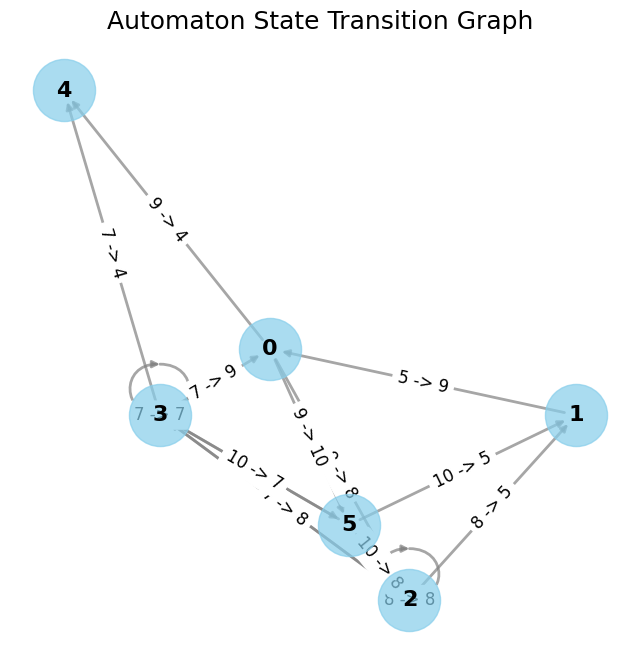

In [24]:
import matplotlib.pyplot as plt
import networkx as nx

# Define your states and transition_to
# Each state will have an index and a list of transitions (indices of next states)


# Create a directed graph
G = nx.DiGraph()

# Add nodes (states)
for i, state in enumerate(states):
    G.add_node(i, label=state.state_identifier)

# Add edges based on transitions
for i, state in enumerate(states):
    for next_state_idx in state.transition_to:
        G.add_edge(i, next_state_idx, label=f'{states[i].state_identifier} -> {states[next_state_idx].state_identifier}')

# Create a layout for the graph (positions of nodes)
pos = nx.spring_layout(G, seed=42)  # This gives a good-looking layout

# Draw the graph
plt.figure(figsize=(8, 8))

# Draw nodes (states)
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue', alpha=0.7)

# Draw edges (transitions)
nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, edge_color='gray')

# Draw labels for nodes (state identifiers)
nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold')

# Draw edge labels (transition labels)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

# Title and display the plot
plt.title("Automaton State Transition Graph", fontsize=18)
plt.axis('off')  # Hide axes for better aesthetics
plt.show()


In [ ]:
run_spaceex